# Paddy on my own

I will attempt to do paddy on my own! Let's go!

In [1]:
from fastai.vision.all import *

In [2]:
path = Path()
path.ls()

(#7) [Path('sample_submission.csv'),Path('test_images'),Path('paddy2.ipynb'),Path('train_images'),Path('paddy.ipynb'),Path('.ipynb_checkpoints'),Path('train.csv')]

## Explore data

Setting the training path

In [3]:
trn_path = path/'train_images'
trn_path.ls()

(#11) [Path('train_images/bacterial_panicle_blight'),Path('train_images/dead_heart'),Path('train_images/tungro'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/bacterial_leaf_streak'),Path('train_images/brown_spot'),Path('train_images/bacterial_leaf_blight'),Path('train_images/downy_mildew'),Path('train_images/models')...]

In [4]:
files = get_image_files(trn_path)
files

(#10407) [Path('train_images/bacterial_panicle_blight/109162.jpg'),Path('train_images/bacterial_panicle_blight/109183.jpg'),Path('train_images/bacterial_panicle_blight/101765.jpg'),Path('train_images/bacterial_panicle_blight/101592.jpg'),Path('train_images/bacterial_panicle_blight/104770.jpg'),Path('train_images/bacterial_panicle_blight/110190.jpg'),Path('train_images/bacterial_panicle_blight/106643.jpg'),Path('train_images/bacterial_panicle_blight/104269.jpg'),Path('train_images/bacterial_panicle_blight/108023.jpg'),Path('train_images/bacterial_panicle_blight/107676.jpg')...]

Look at the image.

(480, 640)


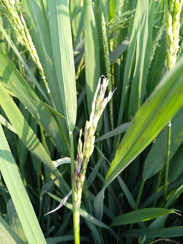

In [5]:
im = PILImage.create(files[0])
print(im.size)
im.to_thumb(244)

Check sizes of all images.

In [6]:
from fastcore.parallel import *

def get_img_size(path):
    return PILImage.create(path).size

sizes = parallel(get_img_size, files)
sizes

(#10407) [(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640)...]

In [7]:
sizes = pd.Series(sizes)
sizes.value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

## Create dataloaders

In [8]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(size=(244)),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
)

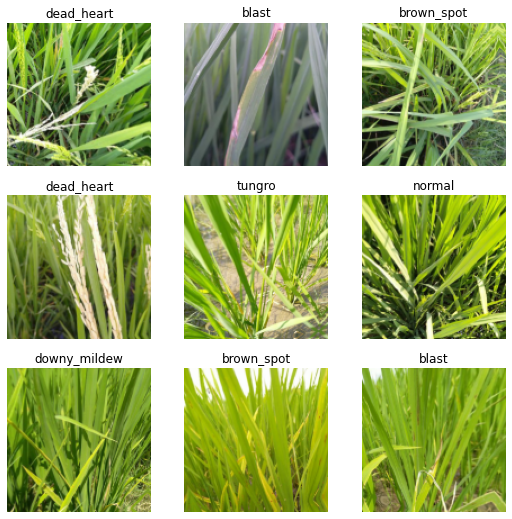

In [9]:
dls.show_batch()

## Learner

In [21]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [17]:
Adam??

Signature:
Adam(
    params,
    lr,
    mom=0.9,
    sqr_mom=0.99,
    eps=1e-05,
    wd=0.01,
    decouple_wd=True,
)
Source:   
def Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-5, wd=0.01, decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, adam_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)
File:      /usr/local/lib/python3.9/dist-packages/fastai/optimizer.py
Type:      function


SuggestedLRs(valley=0.002511886414140463)

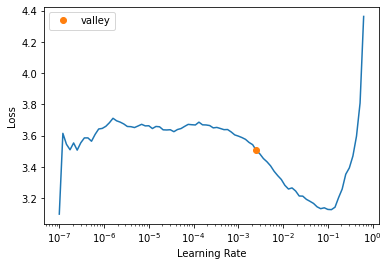

In [14]:
learn.lr_find()

In [23]:
learn.fine_tune(12, base_lr=0.02)

epoch,train_loss,valid_loss,error_rate,time
0,1.975052,1.441903,0.439212,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.885277,0.586416,0.186449,00:45
1,0.713105,0.604622,0.180202,00:46
2,0.707050,0.728302,0.196540,00:46
3,0.617046,1.141670,0.302259,00:45
4,0.522861,0.502858,0.160019,00:46
5,0.409808,0.456056,0.137914,00:45
6,0.301451,0.471849,0.129745,00:45
7,0.248716,0.225235,0.059587,00:45
8,0.171974,0.182276,0.047573,00:46
9,0.122043,0.157556,0.043248,00:45


In [24]:
doc(learn.fit_one_cycle)

In [25]:
learn.export('res34_12.pkl')

## Inference

In [29]:
ss = pd.read_csv('sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [31]:
test_path = get_image_files(path/'test_images').sorted()
test_path

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

In [34]:
test_dl = dls.test_dl(test_path)
test_dl

In [36]:
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [37]:
idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

In [39]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [41]:
idxs = pd.Series(idxs)
idxs

0       7
1       8
2       3
3       3
4       3
       ..
3464    5
3465    7
3466    8
3467    1
3468    5
Length: 3469, dtype: int64

In [42]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [46]:
results = idxs.map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Length: 3469, dtype: object

In [48]:
ss.label = results
ss

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [49]:
ss.to_csv('subm.csv', index=False)

In [50]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
